In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
import warnings
warnings.filterwarnings('ignore')

# EDA

In [4]:
df= pd.read_csv('/kaggle/input/cards-image-datasetclassification/cards.csv')
df.head()

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8155 entries, 0 to 8154
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class index  8155 non-null   int64 
 1   filepaths    8155 non-null   object
 2   labels       8155 non-null   object
 3   card type    8155 non-null   object
 4   data set     8155 non-null   object
dtypes: int64(1), object(4)
memory usage: 318.7+ KB


In [6]:
train_data= df[df['data set']=='train']
train_data = train_data.drop(['filepaths', 'data set'], axis=1)
train_data.head()

,class index,labels,card type
0,0,ace of clubs,ace
1,0,ace of clubs,ace
2,0,ace of clubs,ace
3,0,ace of clubs,ace
4,0,ace of clubs,ace


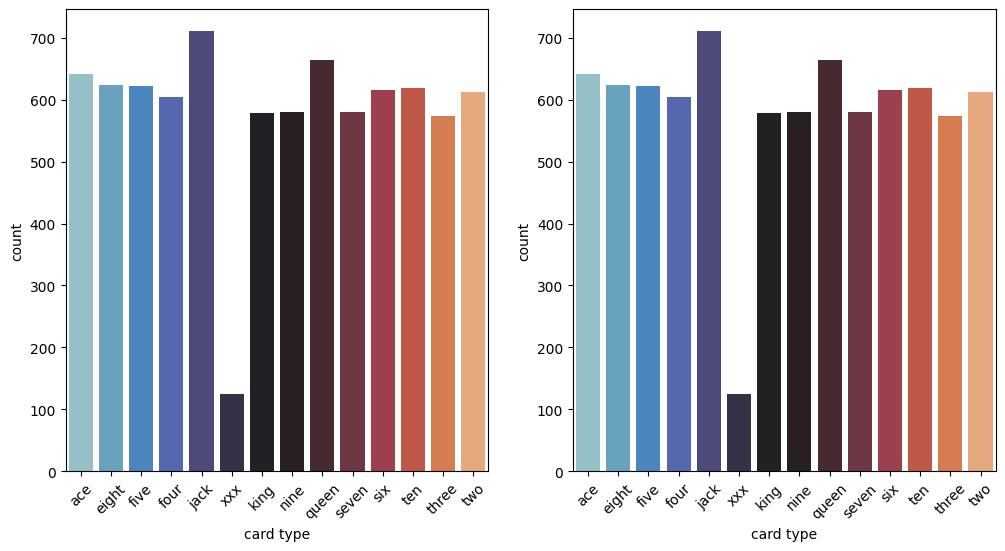

In [7]:
fig, axs= plt.subplots(1, 2, figsize=(12, 6))
plot = sns.countplot(data= df, x='card type', palette = 'icefire', ax= axs[0])
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot2 = sns.countplot(data= df, x='card type', palette= 'icefire', ax= axs[1])
plot2.set_xticklabels(plot2.get_xticklabels(), rotation=45)
plt.show()

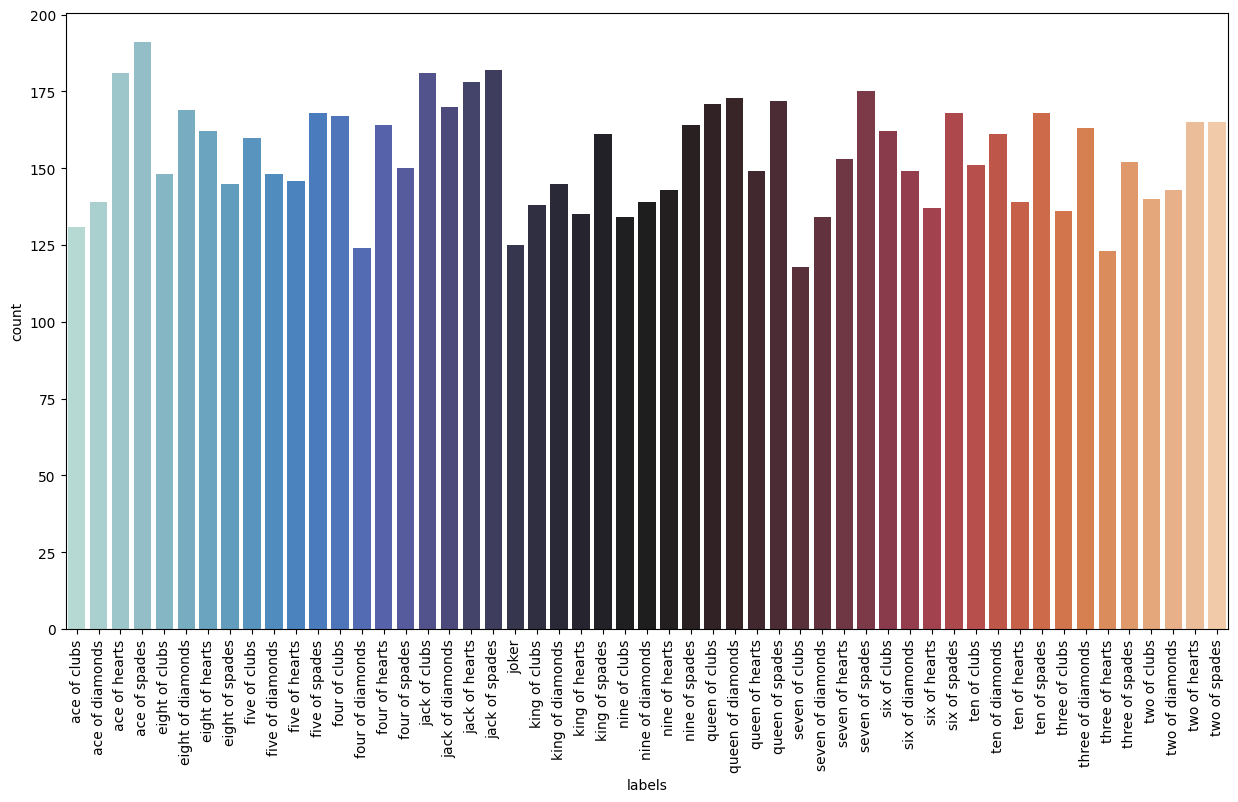

In [8]:
plt.figure(figsize=(15,8))
plot3 = sns.countplot(data= df, x= 'labels', palette = 'icefire')
plot3.set_xticklabels(plot3.get_xticklabels(), rotation=90)
plt.show()

# Data loading and preparation

In [15]:
train_images = image_dataset_from_directory('/kaggle/input/cards-image-datasetclassification/train', image_size=(224, 224))
val_images = image_dataset_from_directory('/kaggle/input/cards-image-datasetclassification/valid', image_size=(224, 224))
test_images = image_dataset_from_directory('/kaggle/input/cards-image-datasetclassification/test', image_size=(224, 224))

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.


In [22]:
test_data= df[df['data set']=='test']
test_data = test_data.drop(['filepaths', 'data set', 'card type'], axis=1)
cards_dict = test_data.drop_duplicates(subset=['class index', 'labels']).set_index('class index')['labels'].to_dict()

In [85]:
train_images=[]
train_labels=[]
for image, label in val_images:
    train_images.extend(image.numpy().astype("uint8"))
    train_labels.extend(label.numpy().flatten().tolist())
train_images = np.array(train_images)
train_labels = np.array(train_labels)

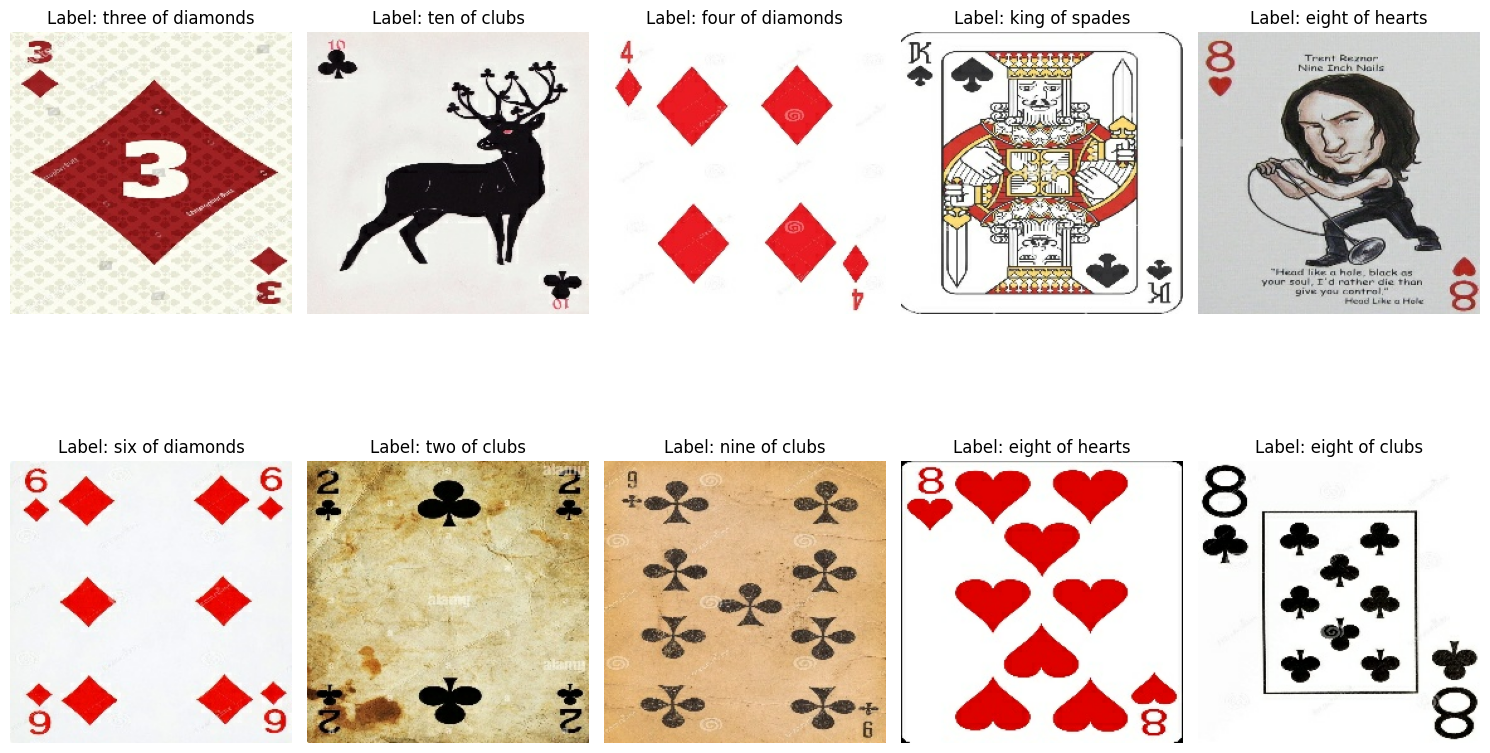

In [86]:
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i])
    plt.title(f"Label: {cards_dict[train_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_images = train_images.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_images = val_images.cache().prefetch(buffer_size=AUTOTUNE)
test_images = test_images.cache().prefetch(buffer_size=AUTOTUNE)

# Building model

In [48]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(224, 224, 3)))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(53, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 53)             │         3,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,612,437 (13.78 MB)

 Trainable params: 3,612,437 (13.78 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
monitor = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss',
                                      save_best_only=True, mode='min')

history=model.fit(train_images,
                  validation_data=val_images,
                  epochs=100,
                  callbacks = [monitor, checkpoint_callback])

Epoch 1/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.0551 - loss: 3.7892 - val_accuracy: 0.3698 - val_loss: 2.0996
Epoch 2/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.4019 - loss: 2.2116 - val_accuracy: 0.6151 - val_loss: 1.3498
Epoch 3/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.5982 - loss: 1.4944 - val_accuracy: 0.7321 - val_loss: 1.0038
Epoch 4/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.7154 - loss: 1.0369 - val_accuracy: 0.7547 - val_loss: 0.9521
Epoch 5/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.7895 - loss: 0.7493 - val_accuracy: 0.7962 - val_loss: 0.8858
Epoch 6/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 344s 1s/step - accuracy: 0.8568 - loss: 0.5197 - val_accuracy: 0.8151 - val_loss: 0.8277
Epoch 7/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.8981 - loss: 0.3505 - val_accuracy: 0.8113 - val_loss: 1.1135
Epoch 8/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - accuracy: 0.9279 - loss: 0.2582 - 

In [58]:
def plot_epochs_accuracy_loss(history):
    fig, axs= plt.subplots(1, 2, figsize=(12, 6))
    sns.lineplot(history.history['accuracy'], ax= axs[0], label='accuracy')
    sns.lineplot(history.history['val_accuracy'], ax= axs[0], label='val_accuracy')
    axs[0].legend()
    sns.lineplot(history.history['loss'], ax= axs[1], label='loss')
    sns.lineplot(history.history['val_loss'], ax= axs[1], label='val_loss')
    axs[1].legend()
    plt.show()

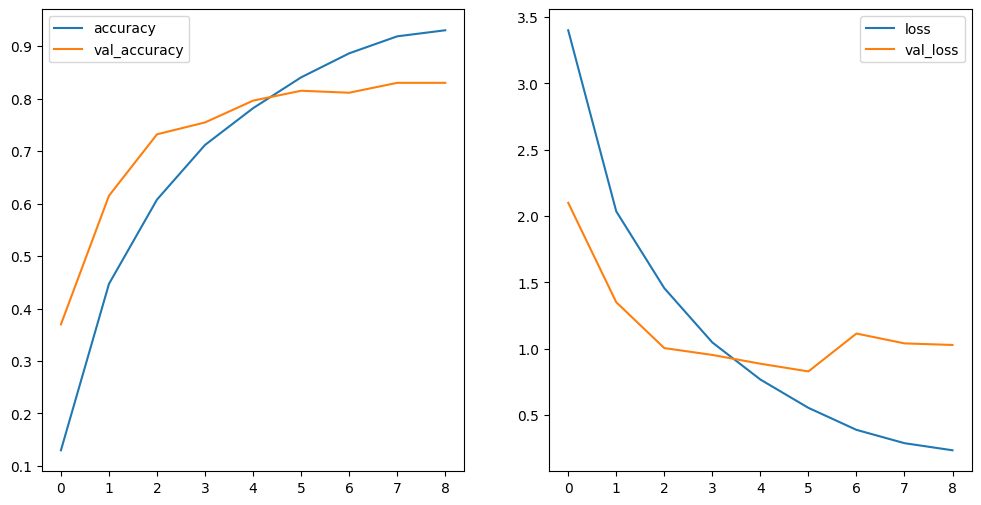

In [61]:
plot_epochs_accuracy_loss(history)

# Working with predictions

In [10]:
from tensorflow.keras.models import load_model
model = load_model("/kaggle/input/best_model_cars2/keras/default/1/best_model.keras")

In [17]:
predictions= model.predict(test_images)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 423ms/step


In [18]:
pred_labels= np.argmax(predictions, axis=1)
print(pred_labels)

[14 25 24  9 47  0 25  7  2  0 13 23  3 25 11 47 43 38 52 41 14  1 32 15
 40  6 37 29  4 44  3 52 28  3 21 23 20  2 44 23 44 28  7  2 38 43 22 33
  3  7 34 10 36 10 50 37 19 48  1 51 46 40 45 17 46 52 41  7 35 13 50 11
  4 16 19  8 34 12 30 22 17 30 19 29 15  0  1  3 24  3  5 31  2 18 11  5
 22 24 35 47  8 34 34 33 50 30  7 23 24 28  3 50 36 12 41 38 18 34 23 44
 21 11 35 47 12  0  9 42 49 51  6 17 19 26 44 13  7 22  6 48 46 35 22 46
 49 12 39 47 48 29 30 27 33 19  5  4 22 28 26 29 23 49 43 44 47  0 31 10
 42 25 15 33 35 30 51 32  9 21  3 46  4 40 11 16 41 16 40 19 11 45 42  2
 23  1 50  3 32 13  0 42  4 10 45 35 28 24 39 30 14 18 34 38 48  5 39 12
  7  6 51 43 27 44  5 13 31 48 43 35  9 36 33 32  1  6 38  2 26 39 20 20
 18 29 36 19 38  6 14 29 27  8 14 17 27 41 44 15  6 51  4 21 28 21 49 31
 40]


In [19]:
images=[]
true_labels=[]
for image, label in test_images:
    images.extend(image.numpy().astype("uint8"))
    true_labels.extend(label.numpy().flatten().tolist())
images = np.array(images)
print(true_labels)

[14, 25, 24, 9, 51, 0, 29, 19, 20, 37, 13, 23, 49, 25, 15, 47, 43, 38, 52, 41, 14, 1, 32, 15, 40, 6, 37, 29, 25, 44, 8, 52, 37, 0, 21, 23, 20, 2, 44, 23, 44, 28, 36, 2, 38, 43, 22, 33, 3, 7, 34, 10, 36, 10, 10, 37, 19, 48, 1, 51, 46, 40, 45, 17, 46, 52, 41, 7, 27, 13, 50, 11, 4, 16, 16, 8, 34, 12, 37, 22, 17, 31, 19, 29, 15, 0, 1, 3, 32, 3, 5, 31, 2, 18, 20, 5, 17, 24, 35, 47, 8, 34, 34, 33, 50, 30, 7, 18, 24, 25, 3, 50, 36, 52, 25, 38, 18, 9, 23, 44, 21, 11, 35, 47, 12, 0, 9, 42, 49, 51, 6, 17, 8, 26, 28, 13, 7, 22, 6, 48, 46, 20, 22, 46, 49, 12, 39, 47, 48, 16, 9, 27, 33, 19, 5, 4, 22, 28, 26, 29, 30, 49, 43, 12, 47, 0, 31, 10, 42, 41, 15, 33, 35, 30, 50, 32, 26, 21, 3, 46, 4, 40, 11, 16, 41, 16, 40, 24, 11, 45, 42, 2, 23, 1, 50, 52, 32, 13, 45, 42, 4, 10, 45, 35, 28, 24, 39, 30, 14, 18, 34, 38, 48, 5, 39, 12, 7, 6, 51, 43, 27, 28, 5, 13, 31, 48, 43, 35, 9, 36, 33, 32, 1, 26, 42, 2, 26, 39, 30, 20, 18, 45, 36, 19, 38, 39, 14, 29, 27, 8, 14, 17, 27, 41, 44, 15, 6, 51, 4, 21, 11, 21, 4

In [20]:
accuracy= accuracy_score(true_labels, pred_labels)
print(accuracy)

0.8301886792452831


In [29]:
print(classification_report(true_labels, pred_labels)

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       0.56      1.00      0.71         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       0.71      1.00      0.83         5
           7       0.71      1.00      0.83         5
           8       1.00      0.60      0.75         5
           9       0.75      0.60      0.67         5
          10       1.00      0.80      0.89         5
          11       0.67      0.80      0.73         5
          12       0.80      0.80      0.80         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      0.80      0.89         5
          16       1.00      0.60      0.75         5
          17       1.00    

**Correctly categorised images**

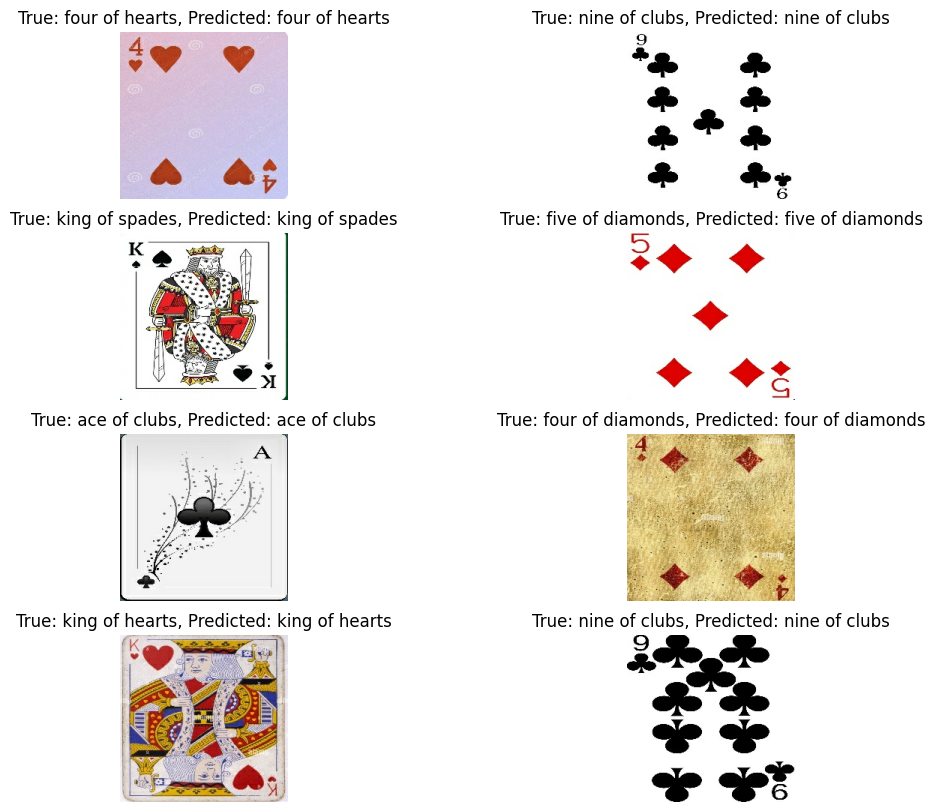

In [23]:
correct_indices = [i for i, (pred, true) in enumerate(zip(pred_labels, true_labels)) if pred == true]

plt.figure(figsize=(12, 10))
for i, idx in enumerate(correct_indices[:8]):
    plt.subplot(4, 2, i + 1)
    plt.imshow(images[idx])
    plt.title(f"True: {cards_dict[true_labels[idx]]}, Predicted: {cards_dict[pred_labels[idx]]}")
    plt.axis('off')
plt.show()

**Misclassified images**

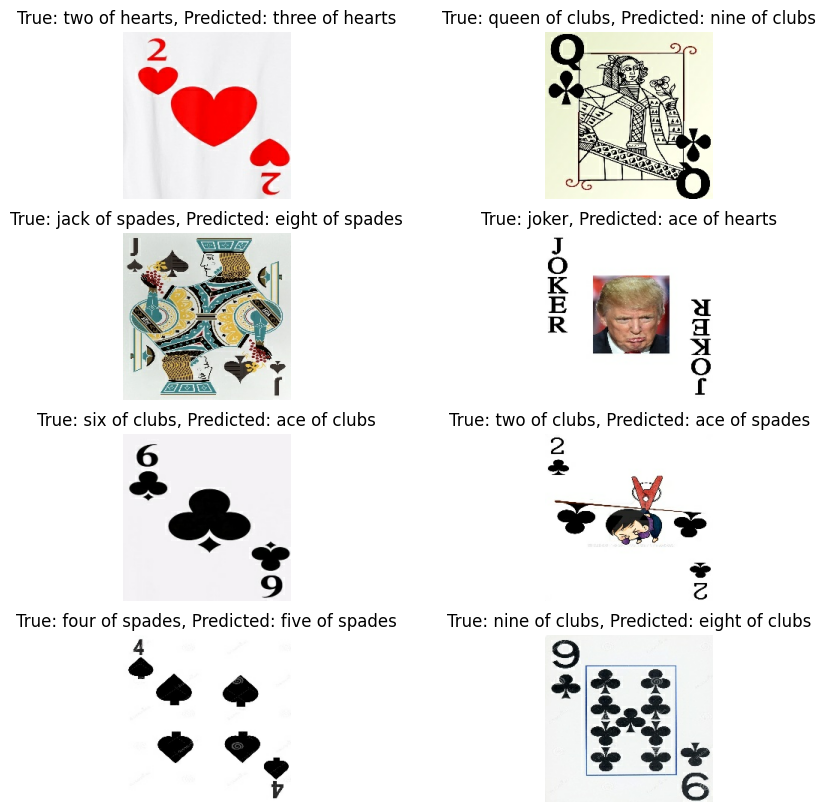

In [24]:
misclassified_indices = [i for i, (pred, true) in enumerate(zip(pred_labels, true_labels)) if pred != true]

plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified_indices[:8]):
    plt.subplot(4, 2, i + 1)
    plt.imshow(images[idx])
    plt.title(f"True: {cards_dict[true_labels[idx]]}, Predicted: {cards_dict[pred_labels[idx]]}")
    plt.axis('off')
plt.show()